In [1]:
!git clone https://github.com/sunghoonYoon/XAI_CAMs "xai"

%cd xai

!mkdir experiments


import os
import os.path as osp

import argparse
import logging

from tqdm import tqdm
import importlib

import random
import numpy as np
import torch
from torch.utils.data import DataLoader
import tools.utils as utils

assert torch.cuda.is_available()



In [2]:
!pip install mxnet-cu112

from google.colab import drive
drive.mount('/content/drive')

In [3]:
# import zipfile
# with zipfile.ZipFile("/content/drive/MyDrive/xai_files/VOC2012/VOC2012.zip","r") as zip_ref:
#     zip_ref.extractall("/content/drive/MyDrive/xai_files/VOC2012")

Start experiment xai!
./experiments/xai already exsits.
---------------------------------------------------- SETUP ----------------------------------------------------
train_list : train
val_list : train
num_workers : 8
batch_size : 8
resize : [256, 448]
crop : 384
lr : 0.01
wt_dec : 0.0005
max_epochs : 15
name : xai
model : model_xai
seed : 4242
vis : False
dict : False
crf : False
print_freq : 100
alphas : [6, 10, 24]
---------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------
------------------------------------------- start train loop --------------------------------------------


  0%|          | 0/1464 [00:00<?, ?it/s]/home/vilab/anaconda3/envs/wsss_ksj/lib/python3.8/site-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


./experiments/xai/val/000_2007_000032_cam_aeroplane.png
./experiments/xai/val/000_2007_000032_cam_person.png


  0%|          | 1/1464 [00:01<44:02,  1.81s/it]

./experiments/xai/val/000_2007_000039_cam_tvmonitor.png


  0%|          | 2/1464 [00:27<6:32:53, 16.12s/it]

./experiments/xai/val/000_2007_000063_cam_chair.png
./experiments/xai/val/000_2007_000063_cam_dog.png


  0%|          | 3/1464 [00:28<3:40:27,  9.05s/it]

./experiments/xai/val/000_2007_000068_cam_bird.png


  0%|          | 4/1464 [00:29<2:17:14,  5.64s/it]

./experiments/xai/val/000_2007_000121_cam_tvmonitor.png


  0%|          | 5/1464 [00:29<1:32:15,  3.79s/it]

./experiments/xai/val/000_2007_000170_cam_bottle.png
./experiments/xai/val/000_2007_000170_cam_person.png


  0%|          | 6/1464 [00:30<1:05:54,  2.71s/it]

./experiments/xai/val/000_2007_000241_cam_boat.png


  0%|          | 6/1464 [00:30<2:03:17,  5.07s/it]


KeyboardInterrupt: 

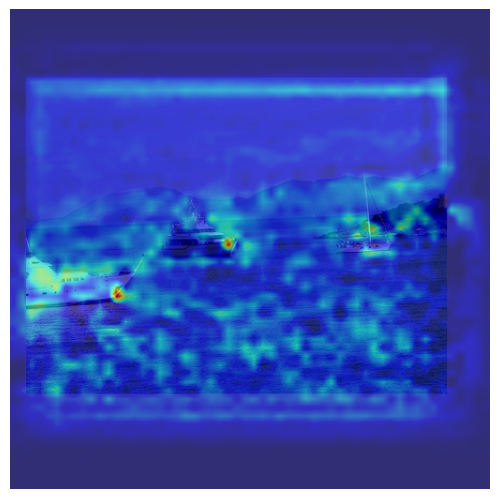

In [4]:
categories = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 
            'bus', 'car', 'cat', 'chair', 'cow', 
            'diningtable', 'dog', 'horse', 'motorbike', 'person', 
            'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

parser = argparse.ArgumentParser()

# Dataset
parser.add_argument("--train_list", default="train", type=str)
parser.add_argument("--val_list", default="train", type=str)
parser.add_argument("--num_workers", default=8, type=int)
parser.add_argument("--batch_size", default=8, type=int)
parser.add_argument("--resize", default=[256,448], nargs='+', type=int)
parser.add_argument("--crop", default=384, type=int)

# Learning rate
parser.add_argument("--lr", default=0.01, type=float)
parser.add_argument("--wt_dec", default=5e-4, type=float)  
parser.add_argument("--max_epochs", default=15, type=int)
parser.add_argument("--name", default='xai', type=str)

# Experiments
parser.add_argument("--model", default='model_xai', type=str) # model_cse
parser.add_argument("--seed", default=4242, type=int)


# Output
parser.add_argument("--vis", action='store_true')
parser.add_argument("--dict", action='store_true')
parser.add_argument("--crf", action='store_true')
parser.add_argument("--print_freq", default=40, type=int)
parser.add_argument("--alphas", default=[6,10,24], nargs='+', type=int)    


args = parser.parse_args(args=[])

print('Start experiment ' + args.name + '!')
exp_path, ckpt_path, train_path, val_path, infer_path, dict_path, crf_path, log_path = utils.make_path(args)

if osp.isfile(log_path):
        os.remove(log_path)

logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

console_handler = logging.StreamHandler()
logger.addHandler(console_handler)

file_handler = logging.FileHandler(log_path)
logger.addHandler(file_handler)

print('-'*52 + ' SETUP ' + '-'*52)
for arg in vars(args):
    print(arg + ' : ' + str(getattr(args, arg)))
print('-'*111)

train_dataset = utils.build_dataset(phase='train', path='voc12/'+args.train_list+'.txt', resize=args.resize, crop=args.crop)
train_data_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=0, pin_memory=True, drop_last=True)

val_dataset = utils.build_dataset(phase='train', path='voc12/'+args.val_list+'.txt')
val_data_loader = DataLoader(val_dataset, shuffle=False, num_workers=0, pin_memory=True)

train_num_img = len(train_dataset)
train_num_batch = len(train_data_loader)

max_step = train_num_img // args.batch_size * args.max_epochs
args.max_step = max_step

model = getattr(importlib.import_module('models.'+args.model), 'model_WSSS')(args)
model.train_setup()

print('-'*111)
print(('-'*43)+' start train loop '+('-'*44))
max_epo = 0
max_miou = 0
max_thres = 0
max_list = []

for epo in range(args.max_epochs):   
    
    # Train
    print('-'*111)
    print('Epoch ' + str(epo).zfill(3) + ' train')
    model.set_phase('train')
    for iter, pack in enumerate(tqdm(train_data_loader)):
        model.unpack(pack)
        model.update(epo)            
        if iter%args.print_freq==0 and iter!=0:
            model.print_log(epo, iter/train_num_batch, logger)
            logger.info('-')           
    model.save_model(epo, ckpt_path)
    model.set_phase('eval')
    
    for iter, pack in enumerate(tqdm(val_data_loader)): 
        model.unpack(pack)
        model.infer(epo, val_path, dict_path, crf_path, vis=iter<50, dict=False, crf=False)
